<a href="https://colab.research.google.com/github/labasubagia22/final-year-project/blob/main/_test/result_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Post Performance Result Analysis




## Import Libraries

In [ ]:
# Install if not exist
!apt-get -qq install -y tree 2> /dev/null

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

## Result Analysis 

### Config

In [ ]:
# Check this if you're the outhor of this notebook
is_author = True #@param {type:"boolean"}

# Other config
plot_title_args = {'fontsize': 14, 'fontweight': 'bold'}

### Constants

In [ ]:
# Keys
KEY_API_COMPOSITION_SEQUENTIAL = 'ACS'
KEY_API_COMPOSITION_PARALLEL = 'ACP'
KEY_API_COMPOSITION_ARRAY = 'ACA'
KEY_CQRS_SINGLE_QUERY = 'CSQ'
KEY_CQRS_MULTIPLE_QUERY = 'CMQ'
KEY_CQRS_MATERIALIZED = 'CM'

# Preditec Types
PREDICT_LINEAR = 'linear'
PREDICT_POLY = 'polynomial'

In [ ]:
# Map Result
RESULT_MAP = {
    KEY_API_COMPOSITION_SEQUENTIAL: {
        'name': 'API Composition Sequential',
        'file': 'api_comp_seq.csv',
        'color': 'blue',
        'url_path': 'posts-api-comp-sequential',
        'predict_type': PREDICT_LINEAR,
    },
    KEY_API_COMPOSITION_PARALLEL: {
        'name': 'API Composition Parallel',
        'file': 'api_comp_par.csv',
        'color': 'green',
        'url_path': 'posts-api-comp-parallel',
        'predict_type': PREDICT_LINEAR,
    },
    KEY_API_COMPOSITION_ARRAY: {
        'name': 'API Composition Array',
        'file': 'api_comp_arr.csv',
        'color': 'red',
        'url_path': 'posts-api-comp-id-array',
        'predict_type': PREDICT_POLY,
    },
    KEY_CQRS_SINGLE_QUERY: {
        'name': 'CQRS Single Query',
        'file': 'cqrs_single.csv',
        'color': 'black',
        'url_path': 'posts-cqrs-query-agg',
        'predict_type': PREDICT_LINEAR,
    },
    KEY_CQRS_MULTIPLE_QUERY: {
        'name': 'CQRS Multiple Query',
        'file': 'cqrs_multi.csv',
        'color': 'orange',
        'url_path': 'posts-cqrs-query-manual',
        'predict_type': PREDICT_POLY,
    },
    KEY_CQRS_MATERIALIZED: {
        'name': 'CQRS Materialized',
        'file': 'cqrs_mat.csv',
        'color': 'purple',
        'url_path': 'posts-cqrs-materialize',
        'predict_type': PREDICT_LINEAR,
    },
}

### Load test result

In [ ]:
RESULT_PATH = '/content/result'
DATASET_PATH = '/content/dataset'

folders = [
    {'id': '1ZC7kunkD5bYJ65zsV0kFWDYHPSQxSneI', 'name': 'result'},
    {'id': '1Z7er2w8iRA0XzrL6dK7ZRvAZ8hKxlPQy', 'name': 'dataset'},
]

if is_author:
    drive.mount('/content/drive')
    for folder in folders:
        os.system(f'ln -s /content/drive/MyDrive/kuliah/skripsi/test_locust/{folder["name"]}/ /content/')
else:
    for folder in folders:
        os.system(f'gdown -q https://drive.google.com/drive/folders/{folder["id"]} -O $RESULT_PATH --folder')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Result Preprocess Functions




In [ ]:
LOCUST_RESULT_COLUMNS = {
    'Request Count': 'sample',
    'Data Size': 'data_size',
    'Average Response Time': 'avg',
    'Min Response Time': 'min',
    'Max Response Time': 'max',
}

def get_locust_result_df(file_path):
    df = pd.read_csv(file_path)
    # remove last row
    df = df.iloc[:-1, :]

    # add data size
    df['Data Size'] = df['Name'].apply(lambda x: int(x.split('limit=')[1]))

    # sort by data size
    df = df.sort_values(by=['Data Size'])

    # select columns
    columns = LOCUST_RESULT_COLUMNS
    df = df[columns.keys()]
    df.rename(columns=columns, inplace=True)
    df.reset_index(inplace=True)

    return  df

def get_step_df(step_dir):
    df = pd.DataFrame()
    for key, value in RESULT_MAP.items():
        result_file = os.path.join(step_dir, value['file'])
        if os.path.exists(result_file):
            file_df = get_locust_result_df(result_file)
            if (not 'sample' in df.columns) or df['sample'].mean() > file_df['sample'].mean():
                df['sample'] = file_df['sample']
            df['data_size'] = file_df['data_size']
            df[key] = file_df['avg']
    return df

def get_locust_dataset_df(dataset_path):
    dataset_df = pd.read_csv(dataset_path)
    dataset_df = dataset_df.iloc[:-1, :]
    dataset_df['Data Size'] = dataset_df['Name'].apply(lambda x: int(x.split('limit=')[1]))
    dataset_df.rename(columns=LOCUST_RESULT_COLUMNS, inplace=True)

    df = pd.DataFrame()
    for key, req_type in RESULT_MAP.items():
        req_df = dataset_df[dataset_df['Name'].str.contains(req_type['url_path'])]
        if not req_df.empty:
            req_df = req_df.sort_values(by=['data_size'])
            req_df = req_df.reset_index(drop=True)
            df[key] = req_df['avg']
            df[f'url_{key}'] = req_df['Name']
            if not 'data_size' in df.columns:
                df['data_size'] = req_df['data_size']

    df.reset_index(drop=True, inplace=True)
    return df

def map_result_path_df(dir=RESULT_PATH):
    map = {}
    server_types = [x for x in os.listdir(dir) if 'skip' not in x]
    for server in server_types:
        map[server] = {}
        steps = [x for x in os.listdir(os.path.join(dir, server)) if 'skip' not in x]
        for step in steps:
            step_dir = os.path.join(dir, server, step) 
            map[server][step] = get_step_df(step_dir)
    return map

### Result Visualization Functions

In [ ]:
PLOT_COLUMNS = [
    KEY_API_COMPOSITION_SEQUENTIAL, 
    KEY_API_COMPOSITION_PARALLEL,
    KEY_API_COMPOSITION_ARRAY,
    KEY_CQRS_SINGLE_QUERY,
    KEY_CQRS_MULTIPLE_QUERY,
    KEY_CQRS_MATERIALIZED
]

def show_result_plot(df, title='', figsize=(8, 6), columns=PLOT_COLUMNS,):
    plt.figure(figsize=figsize)
    for column in columns:
        if column in df.columns:
            m = RESULT_MAP[column]
            plt.plot(df['data_size'], df[column], color=m['color'], label = f"{m['name']} ({column})")
    plt.title(title, **plot_title_args)
    plt.xlabel('data size')
    plt.ylabel('avg response time (ms)')
    plt.legend()
    plt.show()


def visualize_result_path(result_path, configs={}):
    map = map_result_path_df(result_path)
    
    for server, steps in map.items():
        print(f'Test on Server: {server}')
        for step, df in sorted(steps.items()):
            if df.empty:
                continue
            default_columns = ['sample','data_size']
            if step in configs[server]:
                for i, cfg in enumerate(configs[server][step]):
                    conf_df = df.copy()
                    if 'limit' in cfg:
                        lim = cfg['limit']
                        conf_df = conf_df.iloc[lim.get('start', 0):lim.get('end', conf_df.shape[0])]
                    show_result_plot(conf_df, title=f'{step}.{i+1}', columns=cfg['cols'])
    
                    if 'desc' in cfg:
                        print(cfg['desc'], '\n')

                    columns = [x for x in (default_columns+cfg['cols']) if x in df.columns]
                    print(df[columns].to_string(), '\n')
            else:
                show_result_plot(df, step)
                columns = [x for x in (default_columns+PC) if x in df.columns]
                print(df[columns].to_string())
                print()
        print()

### Visualize Result




In [ ]:
# Show 
!tree $RESULT_PATH -L 2

/content/result
└── local
    ├── step1
    ├── step2
    ├── step3
    └── step4

5 directories, 0 files


Test on Server: local


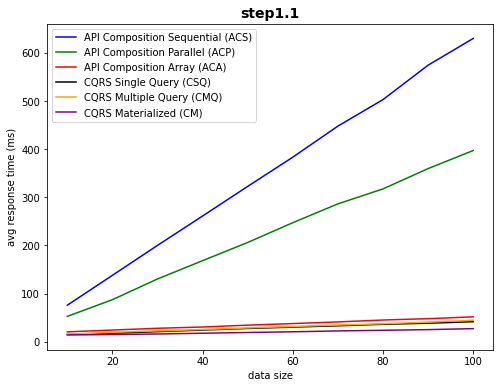

Show all columns 

   sample  data_size         ACS         ACP        ACA        CSQ        CMQ         CM
0     100         10   75.904645   52.616997  20.492875  15.082091  15.447175  14.007806
1     100         20  137.996288   87.374696  24.227868  17.530400  19.671427  14.945136
2     100         30  200.185471  130.374892  27.922353  20.932291  22.545285  16.047059
3     100         40  261.184303  168.387804  30.558537  24.239959  25.290573  17.648627
4     100         50  322.745595  206.199615  34.438308  27.543438  28.623860  19.170676
5     100         60  383.400630  247.284760  37.690001  30.347612  31.663497  20.658179
6     100         70  447.938921  286.370785  41.140425  33.143809  34.665632  22.401889
7     100         80  502.987578  317.459535  45.084205  36.209366  37.355161  23.762552
8     100         90  574.464359  359.631371  47.860924  38.422400  40.780131  25.110558
9     100        100  629.967422  397.153053  51.691116  41.590090  44.666472  27.180805 



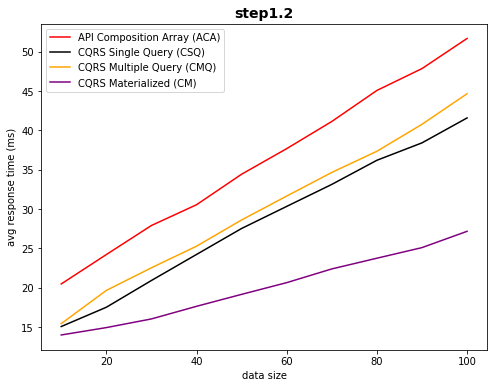

Detailed column ['ACA', 'CSQ', 'CMQ', 'CM'] 

   sample  data_size        ACA        CSQ        CMQ         CM
0     100         10  20.492875  15.082091  15.447175  14.007806
1     100         20  24.227868  17.530400  19.671427  14.945136
2     100         30  27.922353  20.932291  22.545285  16.047059
3     100         40  30.558537  24.239959  25.290573  17.648627
4     100         50  34.438308  27.543438  28.623860  19.170676
5     100         60  37.690001  30.347612  31.663497  20.658179
6     100         70  41.140425  33.143809  34.665632  22.401889
7     100         80  45.084205  36.209366  37.355161  23.762552
8     100         90  47.860924  38.422400  40.780131  25.110558
9     100        100  51.691116  41.590090  44.666472  27.180805 



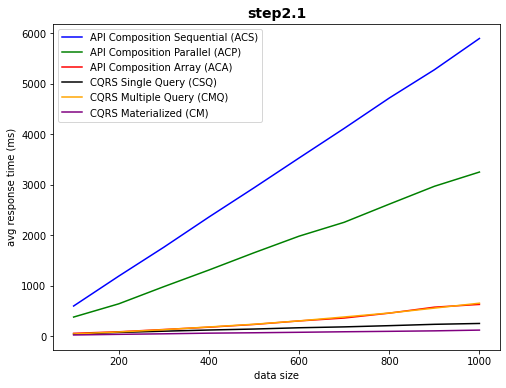

Show all columns 

   sample  data_size          ACS          ACP         ACA         CSQ         CMQ          CM
0     100        100   597.914195   379.230101   57.388164   41.309987   45.668840   24.644277
1     100        200  1188.953734   640.936855   87.854374   74.727276   83.970194   37.262648
2     100        300  1761.202018   980.841673  132.788063   99.576476  129.178028   47.733158
3     100        400  2358.512973  1310.063603  178.856103  122.820182  183.106369   60.626466
4     100        500  2937.158540  1651.632825  232.844572  142.222769  237.106020   68.418170
5     100        600  3527.784040  1980.354300  302.560739  167.583379  303.634063   77.793561
6     100        700  4113.425361  2254.971579  359.951190  184.805357  380.923159   88.128502
7     100        800  4714.381778  2614.162708  456.840049  208.947755  459.473138   96.687610
8     100        900  5273.795559  2967.349897  575.064528  235.607046  556.233325  106.237490
9     100       1000  5893.5433

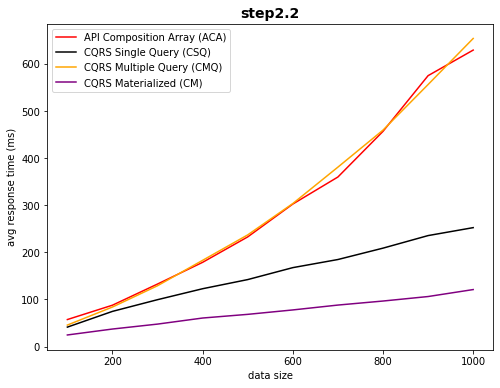

Detailed column ['ACA', 'CSQ', 'CMQ', 'CM']
We can see that ACA and CMQ starting to increase. 

   sample  data_size         ACA         CSQ         CMQ          CM
0     100        100   57.388164   41.309987   45.668840   24.644277
1     100        200   87.854374   74.727276   83.970194   37.262648
2     100        300  132.788063   99.576476  129.178028   47.733158
3     100        400  178.856103  122.820182  183.106369   60.626466
4     100        500  232.844572  142.222769  237.106020   68.418170
5     100        600  302.560739  167.583379  303.634063   77.793561
6     100        700  359.951190  184.805357  380.923159   88.128502
7     100        800  456.840049  208.947755  459.473138   96.687610
8     100        900  575.064528  235.607046  556.233325  106.237490
9     100       1000  629.334445  252.468849  654.003228  121.025227 



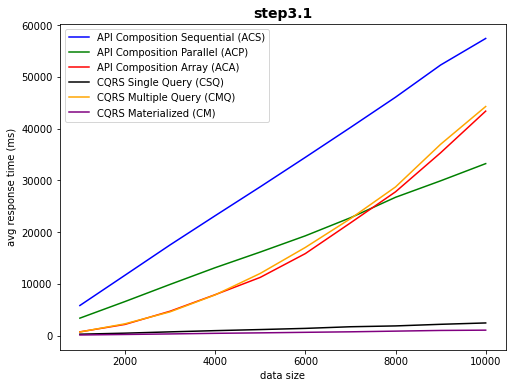

Show all columns 

   sample  data_size           ACS           ACP           ACA          CSQ           CMQ           CM
0      10       1000   5822.246090   3380.241943    728.474906   278.932305    702.332302   127.820021
1      10       2000  11669.445230   6588.056980   2166.939895   476.387949   2284.071602   224.811243
2      10       3000  17528.132501   9897.696642   4716.732280   729.890484   4597.430965   329.073478
3      10       4000  23172.559406  13129.149233   7913.647132   964.800326   7872.615207   447.483460
4      10       5000  28761.315405  16152.015632  11254.886114  1174.133527  12021.735289   536.314209
5      10       6000  34454.503632  19287.472582  15854.760377  1401.073290  17042.948102   641.462802
6      10       7000  40221.387174  22778.107040  21779.127059  1717.345128  22598.973201   738.856695
7      10       8000  46073.675087  26733.045945  27790.405619  1877.749688  28729.918398   870.068805
8      10       9000  52297.024385  29916.086159  3533

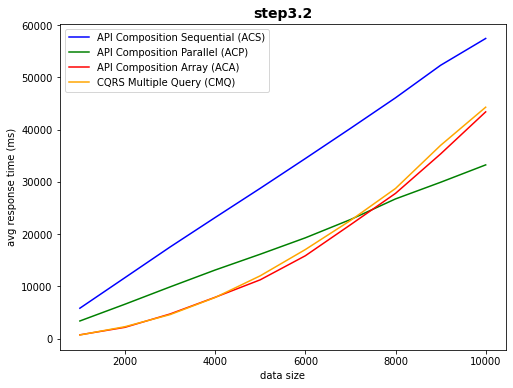

Detailed column ['ACS', 'ACP', 'ACA', 'CMQ']
ACA and CMQ increase significanly and surpass ACP. 

   sample  data_size           ACS           ACP           ACA           CMQ
0      10       1000   5822.246090   3380.241943    728.474906    702.332302
1      10       2000  11669.445230   6588.056980   2166.939895   2284.071602
2      10       3000  17528.132501   9897.696642   4716.732280   4597.430965
3      10       4000  23172.559406  13129.149233   7913.647132   7872.615207
4      10       5000  28761.315405  16152.015632  11254.886114  12021.735289
5      10       6000  34454.503632  19287.472582  15854.760377  17042.948102
6      10       7000  40221.387174  22778.107040  21779.127059  22598.973201
7      10       8000  46073.675087  26733.045945  27790.405619  28729.918398
8      10       9000  52297.024385  29916.086159  35335.580909  36978.084511
9      10      10000  57428.818639  33243.183044  43386.279270  44278.274882 



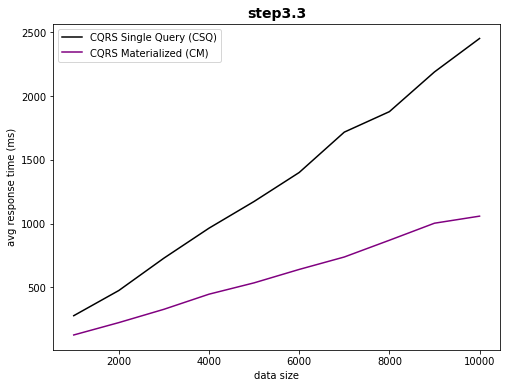

Detailed column ['CSQ', 'CM']
We can see that CSQ and CM stil has the highest performance. 

   sample  data_size          CSQ           CM
0      10       1000   278.932305   127.820021
1      10       2000   476.387949   224.811243
2      10       3000   729.890484   329.073478
3      10       4000   964.800326   447.483460
4      10       5000  1174.133527   536.314209
5      10       6000  1401.073290   641.462802
6      10       7000  1717.345128   738.856695
7      10       8000  1877.749688   870.068805
8      10       9000  2189.024264  1003.627935
9      10      10000  2451.305228  1058.960288 



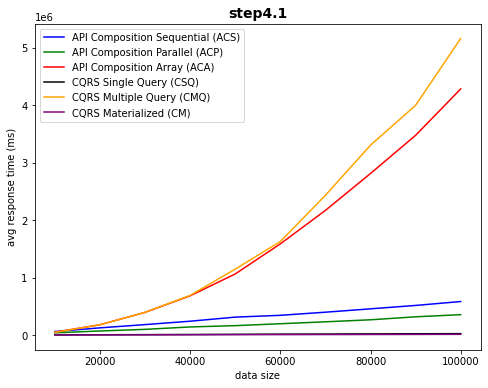

Show all columns 

   sample  data_size            ACS            ACP           ACA           CSQ           CMQ            CM
0       1      10000   61082.215092   38477.848302  5.009205e+04   2449.935573  4.675677e+04   1195.083519
1       1      20000  125080.316412   70770.173677  1.794052e+05   4989.420256  1.779753e+05   2298.728045
2       1      30000  181652.339122   98904.772599  3.943468e+05   7117.676773  3.953062e+05   3645.193978
3       1      40000  240735.325989  141003.039166  6.828874e+05   9795.239468  6.896887e+05   4611.207077
4       1      50000  311641.900588  163408.158616  1.063272e+06  12673.978302  1.147389e+06   6231.578491
5       1      60000  343319.495710  196706.547231  1.586702e+06  15277.334634  1.627660e+06   7578.716196
6       1      70000  397608.510753  230224.336486  2.169293e+06  17245.405842  2.431875e+06   8484.144719
7       1      80000  456097.416505  265439.329156  2.811411e+06  19731.496050  3.304305e+06   9373.113258
8       1      900

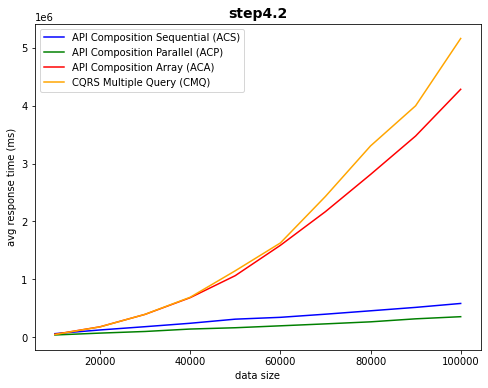

Detailed column ['ACS', 'ACP', 'ACA', 'CMQ'] 

   sample  data_size            ACS            ACP           ACA           CMQ
0       1      10000   61082.215092   38477.848302  5.009205e+04  4.675677e+04
1       1      20000  125080.316412   70770.173677  1.794052e+05  1.779753e+05
2       1      30000  181652.339122   98904.772599  3.943468e+05  3.953062e+05
3       1      40000  240735.325989  141003.039166  6.828874e+05  6.896887e+05
4       1      50000  311641.900588  163408.158616  1.063272e+06  1.147389e+06
5       1      60000  343319.495710  196706.547231  1.586702e+06  1.627660e+06
6       1      70000  397608.510753  230224.336486  2.169293e+06  2.431875e+06
7       1      80000  456097.416505  265439.329156  2.811411e+06  3.304305e+06
8       1      90000  515143.474761  317490.046606  3.475776e+06  3.998108e+06
9       1     100000  583116.937178  354415.442500  4.283547e+06  5.161671e+06 



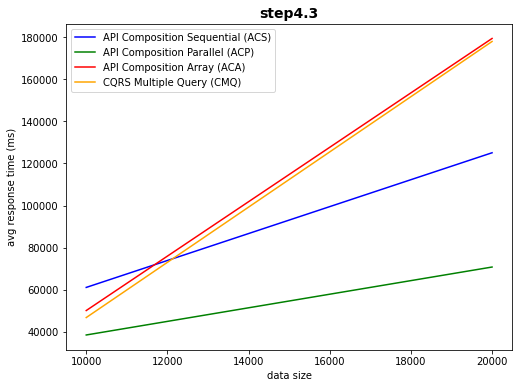

ACA and CMQ surpass the others 

   sample  data_size            ACS            ACP           ACA           CMQ
0       1      10000   61082.215092   38477.848302  5.009205e+04  4.675677e+04
1       1      20000  125080.316412   70770.173677  1.794052e+05  1.779753e+05
2       1      30000  181652.339122   98904.772599  3.943468e+05  3.953062e+05
3       1      40000  240735.325989  141003.039166  6.828874e+05  6.896887e+05
4       1      50000  311641.900588  163408.158616  1.063272e+06  1.147389e+06
5       1      60000  343319.495710  196706.547231  1.586702e+06  1.627660e+06
6       1      70000  397608.510753  230224.336486  2.169293e+06  2.431875e+06
7       1      80000  456097.416505  265439.329156  2.811411e+06  3.304305e+06
8       1      90000  515143.474761  317490.046606  3.475776e+06  3.998108e+06
9       1     100000  583116.937178  354415.442500  4.283547e+06  5.161671e+06 



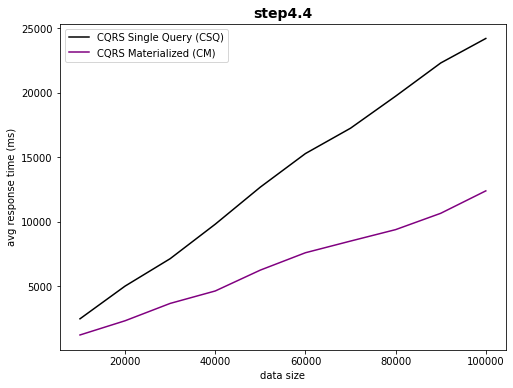

Detailed column ['CSQ', 'CM'] 

   sample  data_size           CSQ            CM
0       1      10000   2449.935573   1195.083519
1       1      20000   4989.420256   2298.728045
2       1      30000   7117.676773   3645.193978
3       1      40000   9795.239468   4611.207077
4       1      50000  12673.978302   6231.578491
5       1      60000  15277.334634   7578.716196
6       1      70000  17245.405842   8484.144719
7       1      80000  19731.496050   9373.113258
8       1      90000  22308.198836  10639.941046
9       1     100000  24210.909971  12381.856208 




In [ ]:
# Config about data visualization
PC = PLOT_COLUMNS
configs = {
    'local': {
        'step1': [
            {
                'cols': PC,
                'desc': 'Show all columns'
            }, 
            {
                'cols': PC[2:],
                'desc': f'Detailed column {PC[2:]}'
            }
        ],
        'step2': [
            {
                'cols': PC,
                'desc': 'Show all columns'
            }, 
            {
                'cols': PC[2:],
                'desc': '\n'.join([
                    f'Detailed column {PC[2:]}',
                    f'We can see that {PC[2]} and {PC[4]} starting to increase.'
                ])
            }
        ],
        'step3': [
            {
                'cols': PC,
                'desc': 'Show all columns',
            },
            {
                'cols': PC[:3]+[PC[4]],
                'desc': '\n'.join([
                    f'Detailed column {PC[:3]+[PC[4]]}',
                    f'{PC[2]} and {PC[4]} increase significanly and surpass {PC[1]}.'
                ])
            },
            {
                'cols': [PC[3],PC[5]],
                'desc': '\n'.join([
                    f'Detailed column {[PC[3],PC[5]]}',
                    f'We can see that {PC[3]} and {PC[5]} stil has the highest performance.'
                ])
            }
        ],
        'step4': [
            {
                'cols': PC,
                'desc': 'Show all columns',
            },
            {
                'cols': PC[:3]+[PC[4]],
                'desc': '\n'.join([
                    f'Detailed column {PC[:3]+[PC[4]]}',
                ])
            },
            {
                'cols': PC[:3]+[PC[4]],
                'limit': { 'start': 0, 'end': 2},
                'desc': '\n'.join([
                    f'{PC[2]} and {PC[4]} surpass the others',
                ])
            },
            {
                'cols': [PC[3],PC[5]],
                'desc': '\n'.join([
                    f'Detailed column {[PC[3],PC[5]]}',
                ])
            }
        ]
    }
}
visualize_result_path(RESULT_PATH, configs)

## Predict data

In [ ]:
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def scaled(data):
    min_max_scaler = MinMaxScaler().fit(data)
    norm = min_max_scaler.transform(data)
    return norm

def build_poly_model(x: pd.Series, y: pd.Series):
    poly = PolynomialFeatures(include_bias=False)
    features = poly.fit_transform(x.to_numpy().reshape(-1, 1))
    model = LinearRegression()
    model.fit(features, y)
    return model

def predict_poly_range(model: LinearRegression, start: int, end: int, divide = 10):
    poly = PolynomialFeatures(include_bias=False)
    x = np.arange(start, end, math.floor(end-start)/divide)
    y = model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y)

def build_linear_model(x: pd.Series, y: pd.Series):
    model = LinearRegression()
    model.fit(x.to_numpy().reshape(-1, 1), y)
    return model

def predict_linear_range(model: LinearRegression, start: int, end: int, divide = 10):
    x = np.arange(start, end, math.floor(end-start)/divide)
    y = model.predict(x.reshape(-1, 1))
    return (x, y)

def load_datasets_from_path(dataset_path=DATASET_PATH):
    dataset_files = [x for x in os.listdir(dataset_path) if 'skip' not in x]
    datasets = []
    for dataset_file in dataset_files:
        ds = get_locust_dataset_df(os.path.join(DATASET_PATH, dataset_file))
        datasets.append({'name': dataset_file, 'dataset': ds})
    return datasets

def load_datasets_from_result_path(result_path=RESULT_PATH):
    map = map_result_path_df(result_path)
    datasets = []
    for server, steps in map.items():
        ds = pd.DataFrame()
        for step, df in sorted(steps.items()):
            if df.empty:
                continue
            if ds.empty:
                ds = df.copy()
            else:
                ds = ds.append(df, ignore_index=True)
        datasets.append({'name': server, 'dataset': ds})
    return datasets

def get_prediction_from_range(ds, start, end, divide=None, predict_type=None):
    range = {'start': start, 'end': end, 'divide': divide if divide else end}
    df = pd.DataFrame()
    config = {
        PREDICT_LINEAR: { 'build_model_fn': build_linear_model,  'predict_fn': predict_linear_range},
        PREDICT_POLY: { 'build_model_fn': build_poly_model,  'predict_fn': predict_poly_range},
    }
    for i, (key, val) in enumerate(RESULT_MAP.items()):
        m = RESULT_MAP[key]
        conf = config[predict_type] if predict_type else config[m['predict_type']]
        model = conf['build_model_fn'](ds['data_size'], ds[key])
        x, y_predicted = conf['predict_fn'](model, **range)
        if df.empty:
            df['data_size'] = pd.Series(x)
        df[key] = pd.Series(y_predicted)
    return df

def visualize_dataset_each_method_prediction(
    y, 
    title,
    ncols=3, 
    ds=None, 
    figsize=(14,8), 
    ds_color='cyan', 
    plot_color=None
):
    nrows = math.ceil(len(RESULT_MAP.keys())/ncols)
    plt.figure(figsize=figsize)
    plt.suptitle(title, **plot_title_args, y=0.94)
    for i, (key, val) in enumerate(RESULT_MAP.items()):
        m = RESULT_MAP[key]
        plt.subplot(nrows, ncols, i+1)
        plt.title(f"{m['name']} ({key})")
        if ds is not None:    
            plt.plot(ds['data_size'], ds[key], color=ds_color, label='dataset')
        color = plot_color if plot_color is not None else m['color']
        plt.plot(y['data_size'], y[key], color=color, label="predicted")
        plt.legend()
    plt.show()

In [ ]:
force_predict_type = "" #@param ["", "linear", "polynomial"]


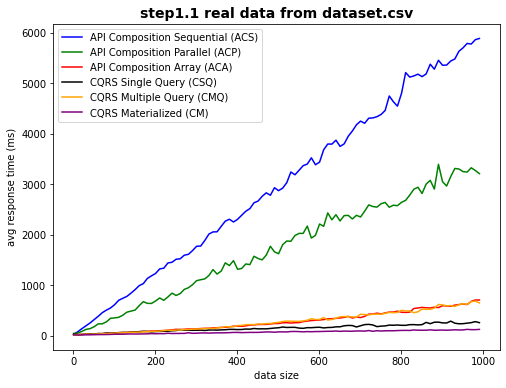

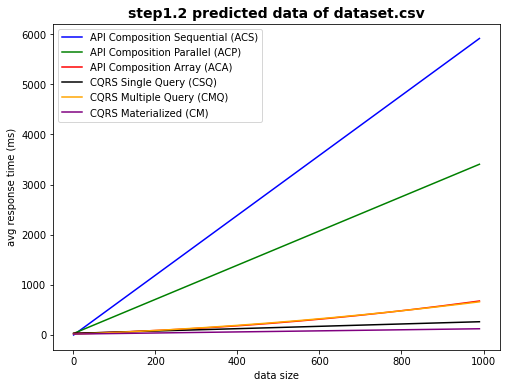

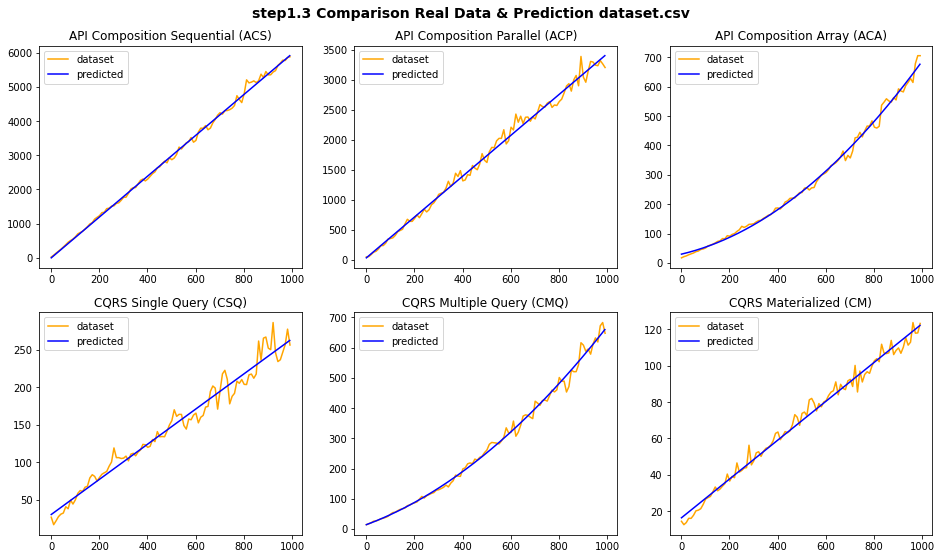

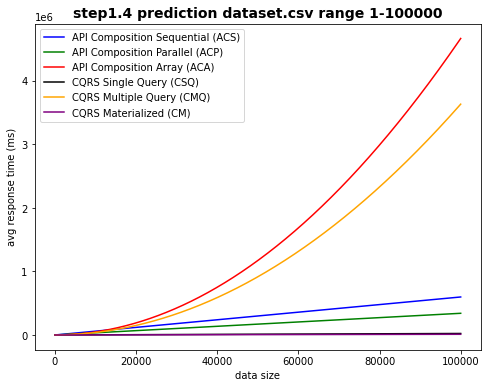

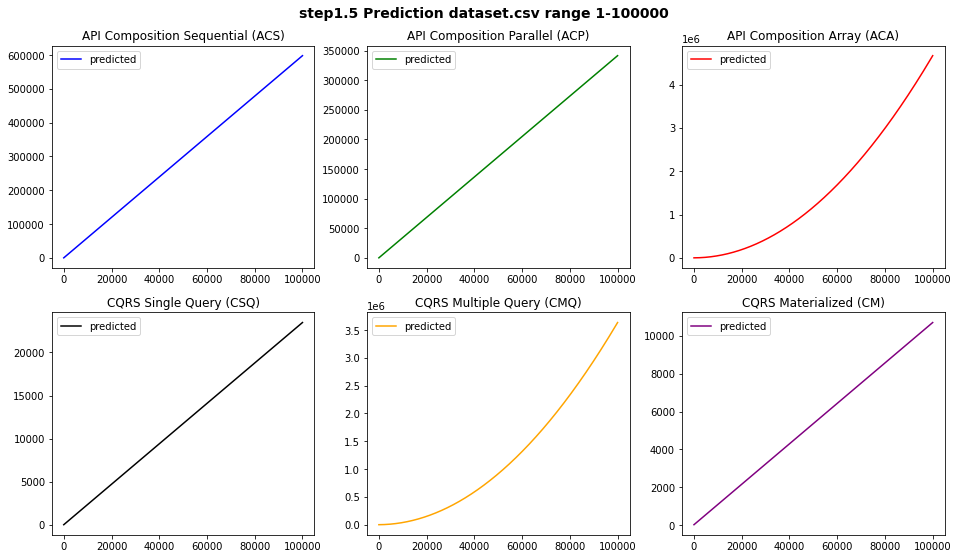

In [ ]:
datasets = load_datasets_from_path(DATASET_PATH)
# datasets = load_datasets_from_result_path(RESULT_PATH)
predict_type = force_predict_type
for i, data in enumerate(datasets):
    ds = data['dataset']
    name = data['name']
    predict_args = {'start': 1, 'end': 100_000}
    ncols = 3
    viz_method_figsize = (16, 9)

    # real data
    show_result_plot(ds, title=f'step{i+1}.1 real data from {name}')
    
    # comparison real data vs it's prediction
    pred = get_prediction_from_range(
        ds, 
        start=ds['data_size'].min(), 
        end=ds['data_size'].max(), 
        predict_type=predict_type
    )
    show_result_plot(pred, title=f'step{i+1}.2 predicted data of {name}')
    visualize_dataset_each_method_prediction(
        ds=ds, 
        y=pred, 
        ncols=ncols, 
        title=f'step{i+1}.3 Comparison Real Data & Prediction {name}', 
        figsize=viz_method_figsize,
        ds_color='orange',
        plot_color='blue'
    )
    print('\n', end='')

    # prediction outside the dataset
    pred = get_prediction_from_range(ds, **predict_args, predict_type=predict_type)
    show_result_plot(pred, title=f'step{i+1}.4 prediction {name} range {predict_args["start"]}-{predict_args["end"]}')
    visualize_dataset_each_method_prediction(
        y=pred, 
        ncols=ncols, 
        title=f'step{i+1}.5 Prediction {name} range {predict_args["start"]}-{predict_args["end"]}', 
        figsize=viz_method_figsize,
    )
    print('\n'*2, end='')